In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset

# Setting device to CUDA if gpu is available, else setting device to CPU
# GPU availability can be checked using torch.cuda.is_available() function call
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

transform = transforms.ToTensor() # convert data to torch.FloatTensor

Device cuda


In [2]:
%matplotlib inline

In [3]:
cd ~/denoise-nn

/mnt/disk2/samarth/denoise-nn


In [4]:
# Creating a custom npy loader
def npy_loader(path):
    sample = torch.from_numpy(np.load(path).astype('float32'))
    return sample

train_dataset_noisy = datasets.DatasetFolder(
    root='train-set/noisy',
    loader=npy_loader,
    extensions=['.npy']
)

train_dataset_target = datasets.DatasetFolder(
     root='train-set/target',
     loader=npy_loader,
     extensions=['.npy']
)

test_dataset_noisy = datasets.DatasetFolder(
    root='test-set/noisy',
    loader=npy_loader,
    extensions=['.npy']
)

test_dataset_target = datasets.DatasetFolder(
     root='test-set/target',
     loader=npy_loader,
     extensions=['.npy']
)

# Using a wrapper to create custom dataset
class DenoisingDataset(Dataset):
    def __init__(self, ds_noisy, ds_target):
        self.ds_noisy = ds_noisy
        self.ds_target = ds_target
        
    def __getitem__(self, index):
        xA = self.ds_noisy[index]
        xB = self.ds_target[index]
        return xA, xB
    
    def __len__(self):
        return len(self.ds_noisy)

In [5]:
train_dataset = DenoisingDataset(train_dataset_noisy, train_dataset_target)
test_dataset = DenoisingDataset(test_dataset_noisy, test_dataset_target)

In [6]:
# Create training and test dataloaders
num_workers = 0  # number of subprocesses to use for data loading
batch_size = 30  # how many samples per batch to load

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class LinearAutoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(LinearAutoencoder, self).__init__()
        ## encoder ##
        self.encoder1 = nn.Linear(500, 250)
        self.encoder2 = nn.Linear(250, 125)
        self.encoder3 = nn.Linear(125, encoding_dim)
        ## decoder ##
        self.decoder1 = nn.Linear(encoding_dim, 125)
        self.decoder2 = nn.Linear(125, 250)
        self.decoder3 = nn.Linear(250, 500)

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        # pass x into encoder
        out = F.relu(self.encoder1(x))
        out = F.relu(self.encoder2(out))
        out = F.relu(self.encoder3(out))
        
        # pass out into decoder
        out = torch.sigmoid(self.decoder1(out))
        out = torch.sigmoid(self.decoder2(out))
        out = torch.sigmoid(self.decoder3(out))
        return out

# initialize the NN
encoding_dim = 64
model = LinearAutoencoder(encoding_dim)
model = model.to(device)
print(model)

LinearAutoencoder(
  (encoder1): Linear(in_features=500, out_features=250, bias=True)
  (encoder2): Linear(in_features=250, out_features=125, bias=True)
  (encoder3): Linear(in_features=125, out_features=64, bias=True)
  (decoder1): Linear(in_features=64, out_features=125, bias=True)
  (decoder2): Linear(in_features=125, out_features=250, bias=True)
  (decoder3): Linear(in_features=250, out_features=500, bias=True)
)


In [8]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))    
        return x

In [9]:
criterion = nn.MSELoss() # specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # specify optimizer function

In [10]:
%%time
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        noisy, target = data
        noisy = noisy[0]
        target = target[0]
        
        # converting to device array
        noisy = noisy.to(device)
        target = target.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(noisy)
        
        # calculate the loss
        loss = criterion(outputs, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()*noisy.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    if n_epochs > 14:
        torch.save(model.state_dict(), f'train-set/model-{epoch}-06.09.2022-14.21.pth')

Epoch: 1 	Training Loss: 0.039783
Epoch: 2 	Training Loss: 0.003078
Epoch: 3 	Training Loss: 0.001723
Epoch: 4 	Training Loss: 0.001540
Epoch: 5 	Training Loss: 0.001429
Epoch: 6 	Training Loss: 0.001372
Epoch: 7 	Training Loss: 0.001323
Epoch: 8 	Training Loss: 0.001286
Epoch: 9 	Training Loss: 0.001257
Epoch: 10 	Training Loss: 0.001229
Epoch: 11 	Training Loss: 0.001205
Epoch: 12 	Training Loss: 0.001179
Epoch: 13 	Training Loss: 0.001168
Epoch: 14 	Training Loss: 0.001151
Epoch: 15 	Training Loss: 0.001135
Epoch: 16 	Training Loss: 0.001124
Epoch: 17 	Training Loss: 0.001120
Epoch: 18 	Training Loss: 0.001100
Epoch: 19 	Training Loss: 0.001092
Epoch: 20 	Training Loss: 0.001085
CPU times: user 24min 7s, sys: 1min 6s, total: 25min 14s
Wall time: 25min 6s


In [12]:
diter = iter(train_loader)
diter = iter(test_loader)

In [25]:
for i in range(n_epochs):
    os.system(f'mv train-set/model-{i}-06.09.2022-14.21.pth train-set/model-{i}-{fsuffix}.pth')

mv: cannot stat 'train-set/model-0-06.09.2022-14.21.pth': No such file or directory


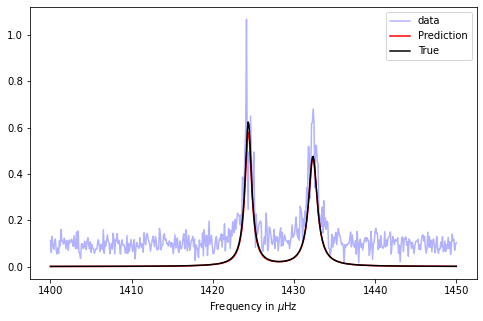

In [13]:
for i in range(20):
    a, b = diter.next()
nnop = model(a[0][10].to(device))

freq = np.linspace(1400, 1450, 500)
plt.figure(figsize=(8, 5))
plt.plot(freq, a[0][10], 'b', alpha=0.3, label='data')
plt.plot(freq, nnop.cpu().detach(), 'r', label='Prediction')
plt.plot(freq, b[0][10], 'k', label='True')
plt.xlabel('Frequency in $\mu$Hz')
plt.legend()
plt.show()



In [23]:
import os
os.system('ls train-set/metadata*.pkl > pkl_name')
with open('pkl_name', 'r') as f:
    metadata_file = f.read().splitlines()
fsuffix = metadata_file[0].split('/')[-1][9:-4]
os.system('rm pkl_name')

torch.save(model.state_dict(), f'train-set/model-{fsuffix}.pth')

# saved model can be loaded using
# encoding_dim = 32
# model = LinearAutoencoder(encoding_dim)
# model.load_state_dict(torch.load(f'train-set/model-{fsuffix}.pth'))

In [27]:
models = []
for i in range(5):
    n_epochs = i+10
    _model = LinearAutoencoder(encoding_dim)
    _model.load_state_dict(torch.load(f'train-set/model-{n_epochs}-{fsuffix}.pth'))
    models.append(_model.to(device))

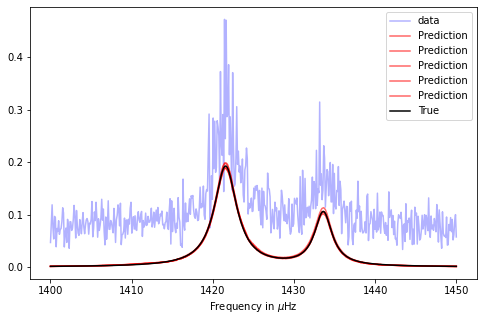

In [35]:
for i in range(20):
    a, b = diter.next()

nnops = []
for i in range(5):
    nnop = models[i](a[0][10].to(device))
    nnops.append(nnop)

freq = np.linspace(1400, 1450, 500)
plt.figure(figsize=(8, 5))
plt.plot(freq, a[0][10], 'b', alpha=0.3, label='data')
for i in range(5):
    plt.plot(freq, nnops[i].cpu().detach(), 'r', alpha=0.6, label='Prediction')
plt.plot(freq, b[0][10], 'k', label='True')
plt.xlabel('Frequency in $\mu$Hz')
plt.legend()
plt.show()
